<table align="center" width=100%>
    <tr>
        <td>
            <div align="center">
                <font color="#38B2FF" size=24px>
                    <b> Predictive Analytics for Healthcare Resource Allocation
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

<br>




### Case Study: Predictive Analytics for Healthcare Resource Allocation

This case study provides an opportunity for an experienced Data Scientist to showcase their expertise in working with healthcare data, developing complex predictive models, and delivering impactful solutions to enhance operational efficiency and resource management in the healthcare industry.

#### Background
The Health EMR company provides a comprehensive electronic medical records system used by healthcare providers. The company has access to a vast amount of anonymized patient health data, including medical histories, diagnoses, treatments, and resource utilization patterns. The data science team aims to leverage this data to develop predictive models that can forecast future resource demands and enable proactive planning and allocation. The goal is to improve patient outcomes, enhance operational efficiency, and optimize resource utilization across healthcare facilities.

#### Tasks
1. **Data Preprocessing and Integration**:
    - Preprocess and integrate the patient health records, resource utilization data, and demographic information.
    - Handle missing values, standardize data formats, and ensure data privacy and security.

2. **Feature Engineering**:
    - Extract relevant features from the patient health records and demographic data to enable accurate resource demand predictions.
    - Transform raw clinical data, aggregate time-series information, incorporate temporal factors, and consider patient-specific characteristics.

3. **Resource Demand Prediction**:
    - Develop predictive models that can forecast resource demands at different healthcare facilities.
    - Utilize machine learning techniques such as regression, time series analysis, or deep learning to predict future resource utilization based on historical patterns and patient attributes.
    - Evaluate the models using appropriate metrics and fine-tune them for optimal performance.

4. **Resource Allocation Optimization**:
    - Optimize the allocation of healthcare resources based on the predictions from the resource demand models.
    - Develop algorithms or decision support tools that consider available resources, service levels, geographical factors, and patient needs to allocate resources efficiently and minimize bottlenecks.
    - Incorporate constraints and objectives from healthcare providers and stakeholders.

5. **Model Interpretability and Explainability**:
    - Ensure the developed models are interpretable and explainable to healthcare professionals and stakeholders.
    - Provide insights into the key factors driving resource demands and highlight any actionable recommendations for resource optimization.

6. **Deployment and Monitoring**:
    - Implement the predictive analytics model into the Health EMR system to provide real-time resource demand predictions.
    - Establish monitoring mechanisms to track model performance, detect anomalies, and update the models periodically as new data becomes available.


In [ ]:
# ! pip install pycaret[full]

In [ ]:
# ! pip install mlflow
# ! pip install ydata_profiling
# ! pip install rapidfuzz
# ! pip install ortools

# 1 Enviroment Setup
The Modules used for this case study.

In [ ]:
import pandas as pd
import numpy as np
import os
import mlflow
from ydata_profiling import ProfileReport
from rapidfuzz import process
from pycaret.regression import *
# Extras
from datetime import date
import warnings
warnings.filterwarnings("ignore")
PATH = "./dataset"
RANDOM_SEED = 142
K_FOLDS = 5

# 2. Loading Data

The dataset is loaded as a Pandas dataframe and a glimpse of the data is shown.

In [6]:
# Load the datasets
hospital_visits = pd.read_csv(f'{PATH}/Patient_Hospital_Visit.csv')
patient_demo = pd.read_csv(f'{PATH}/Patient_Demo.csv')

In [7]:
# Display the first few rows of hospital_visits dataset to understand their structure
hospital_visits.head()

,visit_id,patient_id,institution_id,admitted_at,discharged_at,inserted_at,updated_at,visit_type,type
0,c7febda4-7460-45d9-b5a4-b8d56e0ed102,3KD75TWXQ,4850e9c9-2945-4087-b4f9-6c302e44b84e,NaN,NaN,2021-09-10,2021-09-10 18:30:57.125970,out-patient,hospital
1,5299e941-0936-4e5d-a615-c4ba1c40bd7d,5CQ5ZPTU3,b05bec66-9c3b-4381-9ad2-0636481ca919,NaN,NaN,2021-05-19,2021-05-19 17:00:05.466195,out-patient,hospital
2,79bd7fc4-45c1-4a80-87f0-62b446b66b10,6YNECWS7F,b05bec66-9c3b-4381-9ad2-0636481ca919,NaN,NaN,2021-11-22,2021-11-22 10:28:32.551820,out-patient,hospital
3,eace4e9a-ef8a-433e-8134-4ea2a28a75f8,A456Q4VZ5,f7427dbb-e87d-4ed2-b168-136c244596b2,NaN,NaN,2021-04-16,2021-04-16 09:27:47.728220,out-patient,hospital
4,3250d7a4-05a4-46f0-a561-1d5871e45d89,A89QTDQFZ,60a3c3ea-eff0-4b6a-9d8c-52a6b4fc54e7,NaN,NaN,2021-11-18,2021-11-18 09:28:28.459856,out-patient,hospital


In [8]:
# Display the first few rows of patient_demo dataset to understand their structure
patient_demo.head()

,institution_id,patient_id,dob,sex,state
0,9db63f62-5c58-4303-919e-e23681909271,273KC6WWA,1993-03-06,male,Ogun
1,6762b0cd-12c6-4026-8886-ce15a48a6398,28D62KK5S,1959-04-20,male,kano
2,0fa2e546-c292-4060-a05e-beb53fc31e72,2CEW8BKP6,1935-10-09,female,delta
3,4bb14745-4254-4247-9b84-bd4fc63583b0,2DKKD2X8R,1950-12-03,male,Cross River State
4,3b883d89-83bd-41a1-9eb1-ee76eb22d897,2GBEK724E,1981-07-13,male,Akwa Ibom


In [9]:
# Merge the datasets on patient_id
merged_data = pd.merge(hospital_visits, patient_demo, on='patient_id', how='left')

In [10]:
# Retain only one institution_id
merged_data['institution_id'] = merged_data['institution_id_x'].combine_first(merged_data['institution_id_y'])

# Drop the redundant institution_id columns
merged_data.drop(columns=['institution_id_x', 'institution_id_y'], inplace=True)

In [11]:
merged_data.shape

(448604, 12)

In [12]:
# Display the first few rows of the integrated dataset
merged_data.head()

,visit_id,patient_id,admitted_at,discharged_at,inserted_at,updated_at,visit_type,type,dob,sex,state,institution_id
0,c7febda4-7460-45d9-b5a4-b8d56e0ed102,3KD75TWXQ,NaN,NaN,2021-09-10,2021-09-10 18:30:57.125970,out-patient,hospital,1928-06-01,female,kano,4850e9c9-2945-4087-b4f9-6c302e44b84e
1,5299e941-0936-4e5d-a615-c4ba1c40bd7d,5CQ5ZPTU3,NaN,NaN,2021-05-19,2021-05-19 17:00:05.466195,out-patient,hospital,1981-07-05,female,Ogun,b05bec66-9c3b-4381-9ad2-0636481ca919
2,79bd7fc4-45c1-4a80-87f0-62b446b66b10,6YNECWS7F,NaN,NaN,2021-11-22,2021-11-22 10:28:32.551820,out-patient,hospital,2018-12-27,female,Ogun,b05bec66-9c3b-4381-9ad2-0636481ca919
3,eace4e9a-ef8a-433e-8134-4ea2a28a75f8,A456Q4VZ5,NaN,NaN,2021-04-16,2021-04-16 09:27:47.728220,out-patient,hospital,1987-09-25,female,Ekiti,f7427dbb-e87d-4ed2-b168-136c244596b2
4,3250d7a4-05a4-46f0-a561-1d5871e45d89,A89QTDQFZ,NaN,NaN,2021-11-18,2021-11-18 09:28:28.459856,out-patient,hospital,1990-07-02,female,ekiti,60a3c3ea-eff0-4b6a-9d8c-52a6b4fc54e7


In [13]:
# merged_data.to_csv(f'{PATH}/merged_data.csv', index=False)

# 3 Dataset Overview

In [14]:
profile = ProfileReport(merged_data, title="Profiling Report")

In [15]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

### Key Insights from the Report

**Duplicate Rows:**
- The dataset contains 4 duplicate rows (<0.1%), which need to be addressed to ensure data quality.

**Imbalanced Data:**
- `visit_type` and `type` are highly imbalanced:
    - `visit_type`: 75.7% dominated by a single category.
    - `type`: 74.2% dominated by a single category.
- Imbalances may impact model predictions and require balancing techniques during preprocessing.

**High Missing Values:**
- Key columns with significant missing data:
    - `admitted_at` and `discharged_at`: 96% missing values each.
    - `state`: 25.7% missing values.
- `admitted_at` and `discharged_at` are specific to in-patient visits, which appear limited.

**Correlations:**
- Minimal correlation between key variables (`visit_type`, `type`, and `sex`), suggesting limited direct relationships.
- Highlights the need for feature engineering to extract meaningful relationships.

**Nullity Overview:**
- Most columns have high completeness except for `state`, `admitted_at`, and `discharged_at`.

### Next Steps
1. Handle Duplicate Rows
2. Address Missing Values
3. Handle Outliers
4. Normalize or Scale Numerical Features
5. Feature Engineering
6. Encode Categorical Variables
7. Handle Date-Time Features
8. Drop Irrelevant or Low-Variance Columns

# 4 Data Cleaning and Pre-processing

### Handle Duplicate Rows

In [ ]:
print(f"Number of duplicate rows before: {merged_data.duplicated().sum()}")
merged_data = merged_data.drop_duplicates(keep='first')
print(f"Number of duplicate rows after: {merged_data.duplicated().sum()}")

Number of duplicate rows before: 4
Number of duplicate rows after: 0


### Address Missing Value for state and cleaning

In [ ]:
merged_data['state'] = merged_data['state'].fillna('Unknown')
# List unique values of 'state' and their counts
state_counts = merged_data['state'].value_counts()

# Display the unique values and their counts in an appealing way
print("Unique values of 'state' and their counts:")
for state, count in state_counts.items():
    print(f"{state}: {count}")

Unique values of 'state' and their counts:
Unknown: 115068
LAGOS: 39312
Lagos: 33916
AKS: 18351
lagos: 14813
kano: 13144
Akwa Ibom: 12538
KANO: 10814
Ogun: 10359
delta: 9762
ogun: 8265
Delta: 6854
Oyo: 6773
DELTA: 6659
OYO: 6142
oyo: 5447
IMO: 5083
OGUN: 5003
Lagos State: 4958
Aks: 4856
Enugu: 4106
ENUGU: 3977
FCT: 3975
ONDO: 3906
aks: 3850
AKWA IBOM: 3796
Kano: 3558
LAGOS STATE: 3471
ANAMBRA: 3442
EDO: 2422
OSUN: 2419
kwara: 2274
ondo: 2014
RIVERS: 1922
Anambra: 1895
delta state: 1697
imo: 1678
ABIA: 1659
Kwara: 1654
Imo: 1621
osun: 1548
Edo: 1492
lagos state: 1437
EKITI: 1327
Ondo: 1302
akwa ibom: 1275
KOGI: 1137
south south: 1003
ABUJA: 918
KWARA: 913
Osun: 887
edo: 886
anambra: 882
F.C.T: 824
Ekiti: 764
fct: 755
Akwa Ibom State: 749
Abia: 729
ogun state: 659
enugu: 654
kogi: 642
Abuja: 629
CROSS RIVER: 616
kaduna: 612
Kogi: 612
Ogun State: 610
KADUNA: 601
Benue: 600
ekiti: 595
BENUE: 584
CROSS RIVER STATE: 550
jigawa: 548
Akwa ibom: 520
AKWA IBOM STATE: 507
Ebonyi: 483
abia: 466
ab

Due to the state column containing invalid values (e.g., addresses, misspellings, unrelated entries) and a high number of unique values, we need to reduce the dimensionality of the unique values by separating them into regions. However, before that, we need to handle dirty state data before separating them into regions.

In [ ]:
valid_states = [
    'Abia', 'Adamawa', 'Akwa Ibom', 'Anambra', 'Bauchi', 'Bayelsa', 'Benue', 'Borno',
    'Cross River', 'Delta', 'Ebonyi', 'Edo', 'Ekiti', 'Enugu', 'Gombe', 'Imo', 'Jigawa',
    'Kaduna', 'Kano', 'Katsina', 'Kebbi', 'Kogi', 'Kwara', 'Lagos', 'Nasarawa', 'Niger',
    'Ogun', 'Ondo', 'Osun', 'Oyo', 'Plateau', 'Rivers', 'Sokoto', 'Taraba', 'Yobe', 'Zamfara',
    'FCT'
]

In [ ]:
# Fuzzy match function
def correct_state(state, valid_states):
    # Match state to the closest valid state
    match = process.extractOne(state, valid_states, score_cutoff=70)  # 80% similarity threshold
    if match:
        return match[0]  # Return the matched state
    return 'Unknown'  # If no match, return 'Unknown'

# Apply correction
merged_data['state'] = merged_data['state'].apply(lambda x: correct_state(x, valid_states))


In [ ]:
# Check the distribution of states after correction
print(merged_data['state'].value_counts())

state
Unknown        268870
Lagos           55978
Akwa Ibom       20752
Ogun            19426
Delta           18716
Kano            16759
Oyo              7315
FCT              4896
Enugu            4826
Kwara            4391
Ondo             3409
Anambra          2975
Osun             2557
Imo              1958
Edo              1627
Ekiti            1437
Kogi             1296
Rivers           1093
Benue            1081
Kaduna            959
Cross River       932
Abia              791
Ebonyi            740
Jigawa            712
Niger             669
Taraba            651
Borno             582
Katsina           516
Yobe              427
Nasarawa          391
Gombe             360
Bauchi            338
Adamawa           300
Plateau           228
Kebbi             203
Sokoto            156
Bayelsa           142
Zamfara           141
Name: count, dtype: int64


In [ ]:
# Mapping of states to regions
state_to_region = {
    'Abia': 'South-East', 'Adamawa': 'North-East', 'Akwa Ibom': 'South-South',
    'Anambra': 'South-East', 'Bauchi': 'North-East', 'Bayelsa': 'South-South',
    'Benue': 'North-Central', 'Borno': 'North-East', 'Cross River': 'South-South',
    'Delta': 'South-South', 'Ebonyi': 'South-East', 'Edo': 'South-South',
    'Ekiti': 'South-West', 'Enugu': 'South-East', 'Gombe': 'North-East',
    'Imo': 'South-East', 'Jigawa': 'North-West', 'Kaduna': 'North-West',
    'Kano': 'North-West', 'Katsina': 'North-West', 'Kebbi': 'North-West',
    'Kogi': 'North-Central', 'Kwara': 'North-Central', 'Lagos': 'South-West',
    'Nasarawa': 'North-Central', 'Niger': 'North-Central', 'Ogun': 'South-West',
    'Ondo': 'South-West', 'Osun': 'South-West', 'Oyo': 'South-West',
    'Plateau': 'North-Central', 'Rivers': 'South-South', 'Sokoto': 'North-West',
    'Taraba': 'North-East', 'Yobe': 'North-East', 'Zamfara': 'North-West',
    'FCT': 'North-Central'
}

In [ ]:
# Map state to region
merged_data['region'] = merged_data['state'].map(state_to_region)

# Handle cases where state is 'Unknown' or missing
merged_data['region'] = merged_data['region'].fillna('Uncategorized')


In [ ]:
# Group by region and count visits
region_visit_counts = merged_data.groupby('region')['visit_id'].count().reset_index()
region_visit_counts.rename(columns={'visit_id': 'visit_count'}, inplace=True)
print(region_visit_counts)

          region  visit_count
0  North-Central        12952
1     North-East         2658
2     North-West        19446
3     South-East        11290
4    South-South        43262
5     South-West        90122
6  Uncategorized       268870


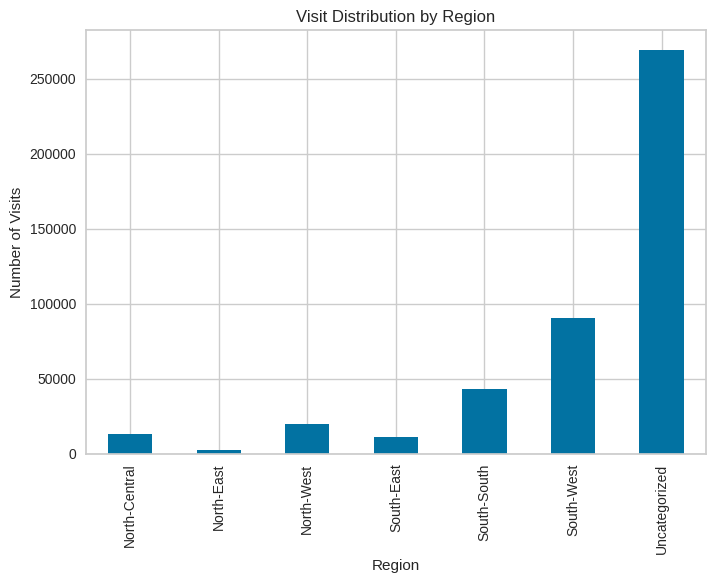

In [ ]:
import matplotlib.pyplot as plt

# Plot the regional distribution
region_visit_counts.plot(kind='bar', x='region', y='visit_count', legend=False)
plt.title('Visit Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Number of Visits')
plt.show()

In [ ]:
# Standardize the 'region' column: strip spaces and convert to lowercase
merged_data['region'] = merged_data['region'].str.strip().str.lower()

# Drop rows where 'region' is 'uncategorized' or 'unknown'
merged_data = merged_data[~merged_data['region'].isin(['uncategorized', 'unknown'])]

# Drop the 'state' column
merged_data = merged_data.drop(columns=['state'])

# Verify the changes
print(f"Remaining rows: {merged_data.shape[0]}")
print(merged_data['region'].unique())  # Check unique values in 'region'
merged_data.head()


Remaining rows: 179730
['north-west' 'south-west' 'south-south' 'north-central' 'south-east'
 'north-east']


,visit_id,patient_id,admitted_at,discharged_at,inserted_at,updated_at,visit_type,type,dob,sex,institution_id,region
0,c7febda4-7460-45d9-b5a4-b8d56e0ed102,3KD75TWXQ,NaN,NaN,2021-09-10,2021-09-10 18:30:57.125970,out-patient,hospital,1928-06-01,female,4850e9c9-2945-4087-b4f9-6c302e44b84e,north-west
1,5299e941-0936-4e5d-a615-c4ba1c40bd7d,5CQ5ZPTU3,NaN,NaN,2021-05-19,2021-05-19 17:00:05.466195,out-patient,hospital,1981-07-05,female,b05bec66-9c3b-4381-9ad2-0636481ca919,south-west
2,79bd7fc4-45c1-4a80-87f0-62b446b66b10,6YNECWS7F,NaN,NaN,2021-11-22,2021-11-22 10:28:32.551820,out-patient,hospital,2018-12-27,female,b05bec66-9c3b-4381-9ad2-0636481ca919,south-west
3,eace4e9a-ef8a-433e-8134-4ea2a28a75f8,A456Q4VZ5,NaN,NaN,2021-04-16,2021-04-16 09:27:47.728220,out-patient,hospital,1987-09-25,female,f7427dbb-e87d-4ed2-b168-136c244596b2,south-west
4,3250d7a4-05a4-46f0-a561-1d5871e45d89,A89QTDQFZ,NaN,NaN,2021-11-18,2021-11-18 09:28:28.459856,out-patient,hospital,1990-07-02,female,60a3c3ea-eff0-4b6a-9d8c-52a6b4fc54e7,south-west


### Address Missing Value for DOB and cleaning

In [ ]:
from datetime import datetime
def calculate_age(dob):
    if pd.isnull(dob):
        return None
    today = datetime.today()
    return today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))


merged_data['dob'] = pd.to_datetime(merged_data['dob'], errors='coerce')
# Recalculate the age column
merged_data['age'] = merged_data['dob'].apply(lambda x: calculate_age(x) if pd.notnull(x) else None)

In [ ]:
print( merged_data['age'].unique())
print(merged_data.shape[0])

[ 96  43   5  37  34  14  53  32  35  81  59  44  48  22  30  41  83   8
  31  46  52  36  73   3  26  27  39  45  10  51  57  55  49  38  40  72
   4  79  60  23  86  68  78  33  29  16   9  50  93  20  18   6  13  92
  54  82  42  88  28  65  56  25  12  76  74  21  66  64  70  61  47  84
  62  80  24  58   7  69  17  11  77  75  67  63  15  19  89  71  85 103
  91  90  87   2  95   1  97 102  94  99 108 105  98 106 104 124 100 110
 109  -5 111]
179730


Based on the unique values for age, we observed the presence of negative ages. We need to handle these negative and extreme values.
We handled negative and extreme values in the 'age' column by defining a valid range (0 to 120), removing rows with invalid ages, imputing missing values with the median, converting ages to integers, and dropping the 'dob' column. Verification steps included printing the number of remaining rows and unique age values, and displaying the first few rows of the modified DataFrame.

In [ ]:
# Handle Negative and Extreme Values

# Define a valid range for age
valid_age_range = (0, 120)


# Remove rows with invalid ages (outside the valid range)
merged_data = merged_data[(merged_data['age'] >= valid_age_range[0]) &
                          (merged_data['age'] <= valid_age_range[1])]


# Impute missing values with the median of the column  Median is more robust for skewed data or when outliers exist.
merged_data['age'] = merged_data['age'].fillna(merged_data['age'].median())


# Convert age to integers
merged_data['age'] = merged_data['age'].round().astype(int)


# Drop the 'dob' column
merged_data = merged_data.drop(columns=['dob'])

# Verify the changes
print(f"Remaining rows: {merged_data.shape[0]}")
print(merged_data['age'].unique())

merged_data.head()

Remaining rows: 179728
[ 96  43   5  37  34  14  53  32  35  81  59  44  48  22  30  41  83   8
  31  46  52  36  73   3  26  27  39  45  10  51  57  55  49  38  40  72
   4  79  60  23  86  68  78  33  29  16   9  50  93  20  18   6  13  92
  54  82  42  88  28  65  56  25  12  76  74  21  66  64  70  61  47  84
  62  80  24  58   7  69  17  11  77  75  67  63  15  19  89  71  85 103
  91  90  87   2  95   1  97 102  94  99 108 105  98 106 104 100 110 109
 111]


,visit_id,patient_id,admitted_at,discharged_at,inserted_at,updated_at,visit_type,type,sex,institution_id,region,age
0,c7febda4-7460-45d9-b5a4-b8d56e0ed102,3KD75TWXQ,NaN,NaN,2021-09-10,2021-09-10 18:30:57.125970,out-patient,hospital,female,4850e9c9-2945-4087-b4f9-6c302e44b84e,north-west,96
1,5299e941-0936-4e5d-a615-c4ba1c40bd7d,5CQ5ZPTU3,NaN,NaN,2021-05-19,2021-05-19 17:00:05.466195,out-patient,hospital,female,b05bec66-9c3b-4381-9ad2-0636481ca919,south-west,43
2,79bd7fc4-45c1-4a80-87f0-62b446b66b10,6YNECWS7F,NaN,NaN,2021-11-22,2021-11-22 10:28:32.551820,out-patient,hospital,female,b05bec66-9c3b-4381-9ad2-0636481ca919,south-west,5
3,eace4e9a-ef8a-433e-8134-4ea2a28a75f8,A456Q4VZ5,NaN,NaN,2021-04-16,2021-04-16 09:27:47.728220,out-patient,hospital,female,f7427dbb-e87d-4ed2-b168-136c244596b2,south-west,37
4,3250d7a4-05a4-46f0-a561-1d5871e45d89,A89QTDQFZ,NaN,NaN,2021-11-18,2021-11-18 09:28:28.459856,out-patient,hospital,female,60a3c3ea-eff0-4b6a-9d8c-52a6b4fc54e7,south-west,34


In [ ]:
def print_unique_values(df, columns):
    for col in columns:
        unique_values = df[col].unique()
        print(f"Unique values in '{col}':")
        for value in unique_values:
            print(f" - {value}")
        print("\n")
        if pd.isnull(value):
            print(" - NaN")
# Specify the columns you want to check
columns_to_check = ['visit_type', 'type', 'sex','region','age']

# Call the function with the merged_data dataframe and the specified columns
print_unique_values(merged_data, columns_to_check)

Unique values in 'visit_type':
 - out-patient
 - in-patient


Unique values in 'type':
 - hospital
 - clinic
 - laboratory


Unique values in 'sex':
 - female
 - male


Unique values in 'region':
 - north-west
 - south-west
 - south-south
 - north-central
 - south-east
 - north-east


Unique values in 'age':
 - 96
 - 43
 - 5
 - 37
 - 34
 - 14
 - 53
 - 32
 - 35
 - 81
 - 59
 - 44
 - 48
 - 22
 - 30
 - 41
 - 83
 - 8
 - 31
 - 46
 - 52
 - 36
 - 73
 - 3
 - 26
 - 27
 - 39
 - 45
 - 10
 - 51
 - 57
 - 55
 - 49
 - 38
 - 40
 - 72
 - 4
 - 79
 - 60
 - 23
 - 86
 - 68
 - 78
 - 33
 - 29
 - 16
 - 9
 - 50
 - 93
 - 20
 - 18
 - 6
 - 13
 - 92
 - 54
 - 82
 - 42
 - 88
 - 28
 - 65
 - 56
 - 25
 - 12
 - 76
 - 74
 - 21
 - 66
 - 64
 - 70
 - 61
 - 47
 - 84
 - 62
 - 80
 - 24
 - 58
 - 7
 - 69
 - 17
 - 11
 - 77
 - 75
 - 67
 - 63
 - 15
 - 19
 - 89
 - 71
 - 85
 - 103
 - 91
 - 90
 - 87
 - 2
 - 95
 - 1
 - 97
 - 102
 - 94
 - 99
 - 108
 - 105
 - 98
 - 106
 - 104
 - 100
 - 110
 - 109
 - 111




In [ ]:
# Rename columns
merged_data.rename(columns={'inserted_at': 'patient_record_created_at', 'type': 'facility_type','updated_at': 'patient_record_updated_at'}, inplace=True)

# Verify the changes
print(merged_data.columns)

merged_data.head()

Index(['visit_id', 'patient_id', 'admitted_at', 'discharged_at',
       'patient_record_created_at', 'patient_record_updated_at', 'visit_type',
       'facility_type', 'sex', 'institution_id', 'region', 'age'],
      dtype='object')


,visit_id,patient_id,admitted_at,discharged_at,patient_record_created_at,patient_record_updated_at,visit_type,facility_type,sex,institution_id,region,age
0,c7febda4-7460-45d9-b5a4-b8d56e0ed102,3KD75TWXQ,NaN,NaN,2021-09-10,2021-09-10 18:30:57.125970,out-patient,hospital,female,4850e9c9-2945-4087-b4f9-6c302e44b84e,north-west,96
1,5299e941-0936-4e5d-a615-c4ba1c40bd7d,5CQ5ZPTU3,NaN,NaN,2021-05-19,2021-05-19 17:00:05.466195,out-patient,hospital,female,b05bec66-9c3b-4381-9ad2-0636481ca919,south-west,43
2,79bd7fc4-45c1-4a80-87f0-62b446b66b10,6YNECWS7F,NaN,NaN,2021-11-22,2021-11-22 10:28:32.551820,out-patient,hospital,female,b05bec66-9c3b-4381-9ad2-0636481ca919,south-west,5
3,eace4e9a-ef8a-433e-8134-4ea2a28a75f8,A456Q4VZ5,NaN,NaN,2021-04-16,2021-04-16 09:27:47.728220,out-patient,hospital,female,f7427dbb-e87d-4ed2-b168-136c244596b2,south-west,37
4,3250d7a4-05a4-46f0-a561-1d5871e45d89,A89QTDQFZ,NaN,NaN,2021-11-18,2021-11-18 09:28:28.459856,out-patient,hospital,female,60a3c3ea-eff0-4b6a-9d8c-52a6b4fc54e7,south-west,34


#### Convert columns to datetime format

In [ ]:
# Convert columns to datetime format
date_columns = ['admitted_at', 'discharged_at', 'patient_record_created_at', 'patient_record_updated_at']
for col in date_columns:
    merged_data[col] = pd.to_datetime(merged_data[col], errors='coerce')

# Verify the changes
print(merged_data[date_columns].dtypes)

admitted_at                  datetime64[ns]
discharged_at                datetime64[ns]
patient_record_created_at    datetime64[ns]
patient_record_updated_at    datetime64[ns]
dtype: object


In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179728 entries, 0 to 448603
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   visit_id                   179728 non-null  object        
 1   patient_id                 179728 non-null  object        
 2   admitted_at                8129 non-null    datetime64[ns]
 3   discharged_at              8163 non-null    datetime64[ns]
 4   patient_record_created_at  179728 non-null  datetime64[ns]
 5   patient_record_updated_at  179728 non-null  datetime64[ns]
 6   visit_type                 179728 non-null  object        
 7   facility_type              179728 non-null  object        
 8   sex                        179728 non-null  object        
 9   institution_id             179728 non-null  object        
 10  region                     179728 non-null  object        
 11  age                        179728 non-null  int64        

# 5. Feature Engineering

##### Time-Based Features

In [ ]:
# Length of stay
merged_data['length_of_stay'] = (pd.to_datetime(merged_data['discharged_at']) -
                                 pd.to_datetime(merged_data['admitted_at'])).dt.days

# Print the number of NaN values before fillna
print(f"Number of NaN values before fillna: {merged_data['length_of_stay'].isna().sum()}")

# Fill NaN length_of_stay with 0 for non-in-patient visits
merged_data['length_of_stay'] = merged_data['length_of_stay'].fillna(0)

# Print the number of NaN values after fillna
print(f"Number of NaN values after fillna: {merged_data['length_of_stay'].isna().sum()}")

# Remove the dot and convert to integers
merged_data['length_of_stay'] = merged_data['length_of_stay'].astype(int)

# Handle -1 values
median_length_of_stay = merged_data['length_of_stay'][merged_data['length_of_stay'] != -1].median()
merged_data['length_of_stay'] = merged_data['length_of_stay'].replace(-1, median_length_of_stay)


print(merged_data['length_of_stay'].unique())

merged_data.head()

Number of NaN values before fillna: 171620
Number of NaN values after fillna: 0
[  0   2   1   5  12   6   4   3   7   8  23   9  80 148  35 315  13  21
  11 172  10  16  92  98  27  29  99  82  46  40 132  34  15 588 129  26
  18  19  17  25 126  14  47  28  63  68  90  30  50 102 119  58 103  31
  24  48  20  42  59  38  81  62  45  49  44  91 111  51  36  41  32 184
 213 201  33  22  54  37 178  39 140 188  65 134 143 190 202 174  79 160
 170  77  89  56 150 154 180 155  67 161  76  57 149 158 177  69 130 114
 138 117 131 101 210 141  84  88 118  72  71 123 189  93  55  61 147  43
  74 285  78  73  83]


,visit_id,patient_id,admitted_at,discharged_at,patient_record_created_at,patient_record_updated_at,visit_type,facility_type,sex,institution_id,region,age,length_of_stay
0,c7febda4-7460-45d9-b5a4-b8d56e0ed102,3KD75TWXQ,NaT,NaT,2021-09-10,2021-09-10 18:30:57.125970,out-patient,hospital,female,4850e9c9-2945-4087-b4f9-6c302e44b84e,north-west,96,0
1,5299e941-0936-4e5d-a615-c4ba1c40bd7d,5CQ5ZPTU3,NaT,NaT,2021-05-19,2021-05-19 17:00:05.466195,out-patient,hospital,female,b05bec66-9c3b-4381-9ad2-0636481ca919,south-west,43,0
2,79bd7fc4-45c1-4a80-87f0-62b446b66b10,6YNECWS7F,NaT,NaT,2021-11-22,2021-11-22 10:28:32.551820,out-patient,hospital,female,b05bec66-9c3b-4381-9ad2-0636481ca919,south-west,5,0
3,eace4e9a-ef8a-433e-8134-4ea2a28a75f8,A456Q4VZ5,NaT,NaT,2021-04-16,2021-04-16 09:27:47.728220,out-patient,hospital,female,f7427dbb-e87d-4ed2-b168-136c244596b2,south-west,37,0
4,3250d7a4-05a4-46f0-a561-1d5871e45d89,A89QTDQFZ,NaT,NaT,2021-11-18,2021-11-18 09:28:28.459856,out-patient,hospital,female,60a3c3ea-eff0-4b6a-9d8c-52a6b4fc54e7,south-west,34,0


In [ ]:

merged_data['number_of_updates'] = merged_data.groupby('patient_id')['patient_record_updated_at'].transform('count').astype(int)
print(merged_data['number_of_updates'].unique())
merged_data.head()

[ 11   5   7   6   4   2  17   3  18   1  12  25  14   8  10   9  62  16
  61  13  15  31  21  19  33  20  24  23  39 156  56  27  45  47  41  26
  22  29  34  28  30  32  35 117  48  38  36  46  37  40  55 111  73  97
  84  82  59  78  52  64  42  44  53  99  43  50  60  69  68  70  49]


,visit_id,patient_id,admitted_at,discharged_at,patient_record_created_at,patient_record_updated_at,visit_type,facility_type,sex,institution_id,region,age,length_of_stay,number_of_updates
0,c7febda4-7460-45d9-b5a4-b8d56e0ed102,3KD75TWXQ,NaT,NaT,2021-09-10,2021-09-10 18:30:57.125970,out-patient,hospital,female,4850e9c9-2945-4087-b4f9-6c302e44b84e,north-west,96,0,11
1,5299e941-0936-4e5d-a615-c4ba1c40bd7d,5CQ5ZPTU3,NaT,NaT,2021-05-19,2021-05-19 17:00:05.466195,out-patient,hospital,female,b05bec66-9c3b-4381-9ad2-0636481ca919,south-west,43,0,5
2,79bd7fc4-45c1-4a80-87f0-62b446b66b10,6YNECWS7F,NaT,NaT,2021-11-22,2021-11-22 10:28:32.551820,out-patient,hospital,female,b05bec66-9c3b-4381-9ad2-0636481ca919,south-west,5,0,7
3,eace4e9a-ef8a-433e-8134-4ea2a28a75f8,A456Q4VZ5,NaT,NaT,2021-04-16,2021-04-16 09:27:47.728220,out-patient,hospital,female,f7427dbb-e87d-4ed2-b168-136c244596b2,south-west,37,0,6
4,3250d7a4-05a4-46f0-a561-1d5871e45d89,A89QTDQFZ,NaT,NaT,2021-11-18,2021-11-18 09:28:28.459856,out-patient,hospital,female,60a3c3ea-eff0-4b6a-9d8c-52a6b4fc54e7,south-west,34,0,4


#### Demographic Features

In [ ]:
# Define corrected age bins and labels
bins = [0, 13, 20, 35, 60, 120]  # Define bin edges
labels = ['child', 'adolescent', 'young adult', 'adult', 'senior']  # Define labels

# Create the age_group column with updated bins
merged_data['age_group'] = pd.cut(
    merged_data['age'], bins=bins, labels=labels, include_lowest=True, right=False
).astype('object')

# Verify the unique values in the new column
print(merged_data['age_group'].value_counts())

# Handle missing or invalid ages
merged_data = merged_data[(merged_data['age'] >= 0) & (merged_data['age'] <= 120)]
merged_data['age'] = merged_data['age'].fillna(merged_data['age'].median())

merged_data['sex_binary'] = merged_data['sex'].map({'male': 0, 'female': 1})
print(merged_data['sex_binary'].unique())
merged_data.head()

age_group
adult          76371
young adult    42428
senior         27222
child          25010
adolescent      8697
Name: count, dtype: int64
[1 0]


,visit_id,patient_id,admitted_at,discharged_at,patient_record_created_at,patient_record_updated_at,visit_type,facility_type,sex,institution_id,region,age,length_of_stay,number_of_updates,age_group,sex_binary
0,c7febda4-7460-45d9-b5a4-b8d56e0ed102,3KD75TWXQ,NaT,NaT,2021-09-10,2021-09-10 18:30:57.125970,out-patient,hospital,female,4850e9c9-2945-4087-b4f9-6c302e44b84e,north-west,96,0,11,senior,1
1,5299e941-0936-4e5d-a615-c4ba1c40bd7d,5CQ5ZPTU3,NaT,NaT,2021-05-19,2021-05-19 17:00:05.466195,out-patient,hospital,female,b05bec66-9c3b-4381-9ad2-0636481ca919,south-west,43,0,5,adult,1
2,79bd7fc4-45c1-4a80-87f0-62b446b66b10,6YNECWS7F,NaT,NaT,2021-11-22,2021-11-22 10:28:32.551820,out-patient,hospital,female,b05bec66-9c3b-4381-9ad2-0636481ca919,south-west,5,0,7,child,1
3,eace4e9a-ef8a-433e-8134-4ea2a28a75f8,A456Q4VZ5,NaT,NaT,2021-04-16,2021-04-16 09:27:47.728220,out-patient,hospital,female,f7427dbb-e87d-4ed2-b168-136c244596b2,south-west,37,0,6,adult,1
4,3250d7a4-05a4-46f0-a561-1d5871e45d89,A89QTDQFZ,NaT,NaT,2021-11-18,2021-11-18 09:28:28.459856,out-patient,hospital,female,60a3c3ea-eff0-4b6a-9d8c-52a6b4fc54e7,south-west,34,0,4,young adult,1


#### Geographical Features

In [ ]:
# Geographical Features
merged_data['region_count'] = merged_data.groupby(['patient_id', 'region']).cumcount() + 1
print(merged_data['region_count'].unique())
merged_data['institution_count'] = merged_data.groupby(['patient_id', 'institution_id']).cumcount() + 1
print(merged_data['institution_count'].unique())

merged_data.head()

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156]
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
 

,visit_id,patient_id,admitted_at,discharged_at,patient_record_created_at,patient_record_updated_at,visit_type,facility_type,sex,institution_id,region,age,length_of_stay,number_of_updates,age_group,sex_binary,region_count,institution_count
0,c7febda4-7460-45d9-b5a4-b8d56e0ed102,3KD75TWXQ,NaT,NaT,2021-09-10,2021-09-10 18:30:57.125970,out-patient,hospital,female,4850e9c9-2945-4087-b4f9-6c302e44b84e,north-west,96,0,11,senior,1,1,1
1,5299e941-0936-4e5d-a615-c4ba1c40bd7d,5CQ5ZPTU3,NaT,NaT,2021-05-19,2021-05-19 17:00:05.466195,out-patient,hospital,female,b05bec66-9c3b-4381-9ad2-0636481ca919,south-west,43,0,5,adult,1,1,1
2,79bd7fc4-45c1-4a80-87f0-62b446b66b10,6YNECWS7F,NaT,NaT,2021-11-22,2021-11-22 10:28:32.551820,out-patient,hospital,female,b05bec66-9c3b-4381-9ad2-0636481ca919,south-west,5,0,7,child,1,1,1
3,eace4e9a-ef8a-433e-8134-4ea2a28a75f8,A456Q4VZ5,NaT,NaT,2021-04-16,2021-04-16 09:27:47.728220,out-patient,hospital,female,f7427dbb-e87d-4ed2-b168-136c244596b2,south-west,37,0,6,adult,1,1,1
4,3250d7a4-05a4-46f0-a561-1d5871e45d89,A89QTDQFZ,NaT,NaT,2021-11-18,2021-11-18 09:28:28.459856,out-patient,hospital,female,60a3c3ea-eff0-4b6a-9d8c-52a6b4fc54e7,south-west,34,0,4,young adult,1,1,1


#### Visit-Related Features

In [ ]:
merged_data['total_visits'] = merged_data.groupby('patient_id')['visit_id'].transform('count')
merged_data['facility_type_count'] = merged_data.groupby(['patient_id', 'facility_type']).cumcount() + 1
merged_data['facility_type_count'] = merged_data['facility_type_count'].fillna(0).astype(int)


print(merged_data['total_visits'].unique())
print(merged_data['facility_type_count'].unique())

merged_data.head()

[ 11   5   7   6   4   2  17   3  18   1  12  25  14   8  10   9  62  16
  61  13  15  31  21  19  33  20  24  23  39 156  56  27  45  47  41  26
  22  29  34  28  30  32  35 117  48  38  36  46  37  40  55 111  73  97
  84  82  59  78  52  64  42  44  53  99  43  50  60  69  68  70  49]
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156]


,visit_id,patient_id,admitted_at,discharged_at,patient_record_created_at,patient_record_updated_at,visit_type,facility_type,sex,institution_id,region,age,length_of_stay,number_of_updates,age_group,sex_binary,region_count,institution_count,total_visits,facility_type_count
0,c7febda4-7460-45d9-b5a4-b8d56e0ed102,3KD75TWXQ,NaT,NaT,2021-09-10,2021-09-10 18:30:57.125970,out-patient,hospital,female,4850e9c9-2945-4087-b4f9-6c302e44b84e,north-west,96,0,11,senior,1,1,1,11,1
1,5299e941-0936-4e5d-a615-c4ba1c40bd7d,5CQ5ZPTU3,NaT,NaT,2021-05-19,2021-05-19 17:00:05.466195,out-patient,hospital,female,b05bec66-9c3b-4381-9ad2-0636481ca919,south-west,43,0,5,adult,1,1,1,5,1
2,79bd7fc4-45c1-4a80-87f0-62b446b66b10,6YNECWS7F,NaT,NaT,2021-11-22,2021-11-22 10:28:32.551820,out-patient,hospital,female,b05bec66-9c3b-4381-9ad2-0636481ca919,south-west,5,0,7,child,1,1,1,7,1
3,eace4e9a-ef8a-433e-8134-4ea2a28a75f8,A456Q4VZ5,NaT,NaT,2021-04-16,2021-04-16 09:27:47.728220,out-patient,hospital,female,f7427dbb-e87d-4ed2-b168-136c244596b2,south-west,37,0,6,adult,1,1,1,6,1
4,3250d7a4-05a4-46f0-a561-1d5871e45d89,A89QTDQFZ,NaT,NaT,2021-11-18,2021-11-18 09:28:28.459856,out-patient,hospital,female,60a3c3ea-eff0-4b6a-9d8c-52a6b4fc54e7,south-west,34,0,4,young adult,1,1,1,4,1


In [ ]:
# Drop the specified columns
columns_to_drop = ['institution_id', 'visit_id', 'patient_id', 'admitted_at', 'discharged_at', 'patient_record_created_at', 'patient_record_updated_at']
merged_data.drop(columns=columns_to_drop, inplace=True)

# Separate numeric columns from object columns
numeric_columns = merged_data.select_dtypes(include=[np.number]).columns.tolist()
object_columns = merged_data.select_dtypes(include=[object]).columns.tolist()

print("Numeric columns:", numeric_columns)
print("Object columns:", object_columns)

merged_data.head()

Numeric columns: ['age', 'length_of_stay', 'number_of_updates', 'sex_binary', 'region_count', 'institution_count', 'total_visits', 'facility_type_count']
Object columns: ['visit_type', 'facility_type', 'sex', 'region', 'age_group']


,visit_type,facility_type,sex,region,age,length_of_stay,number_of_updates,age_group,sex_binary,region_count,institution_count,total_visits,facility_type_count
0,out-patient,hospital,female,north-west,96,0,11,senior,1,1,1,11,1
1,out-patient,hospital,female,south-west,43,0,5,adult,1,1,1,5,1
2,out-patient,hospital,female,south-west,5,0,7,child,1,1,1,7,1
3,out-patient,hospital,female,south-west,37,0,6,adult,1,1,1,6,1
4,out-patient,hospital,female,south-west,34,0,4,young adult,1,1,1,4,1


# 6. Data scaling, Outlier detection and Correlation Analysis

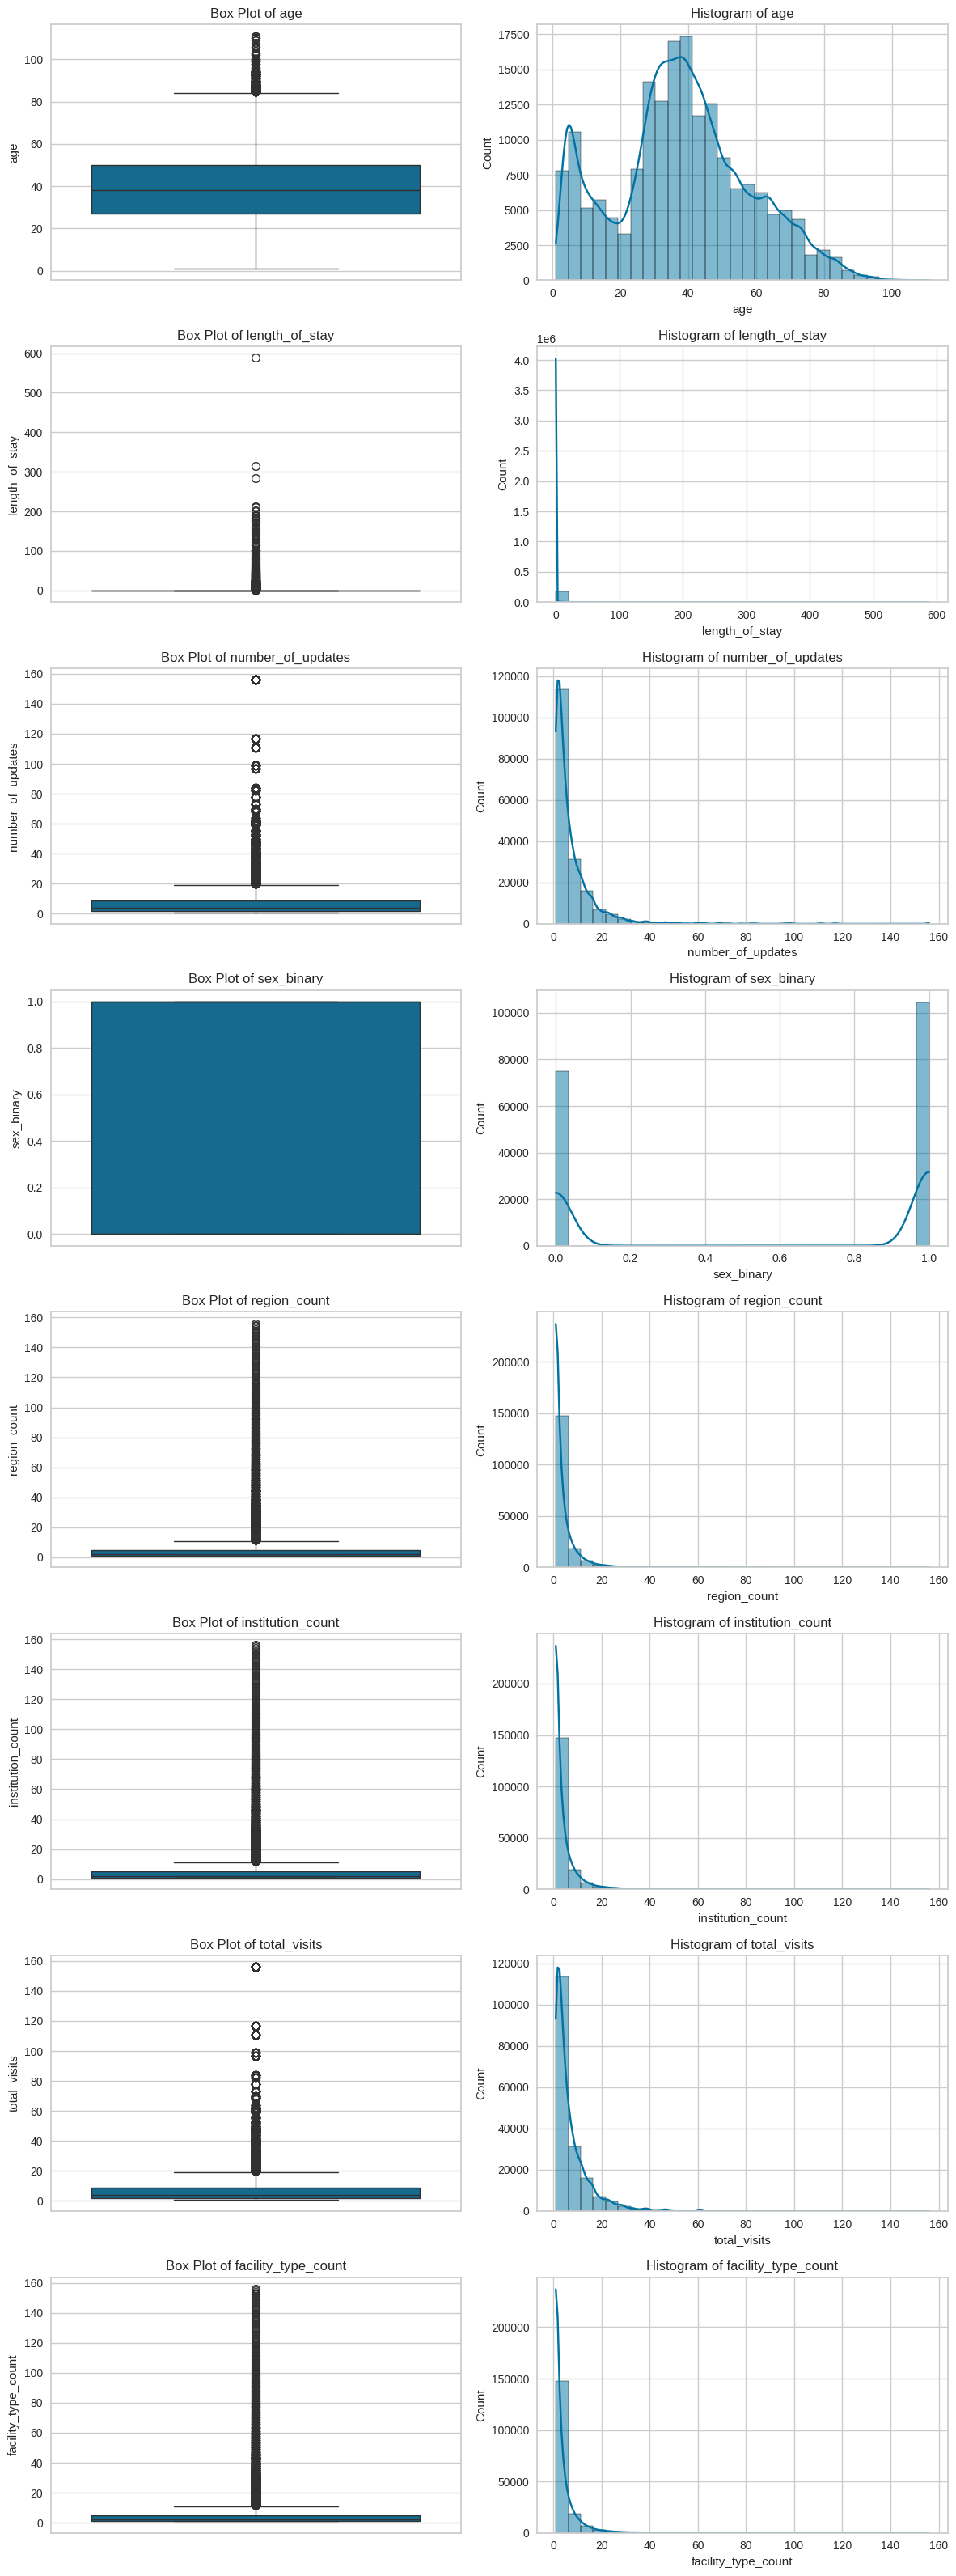

In [ ]:
fig, axes = plt.subplots(nrows=len(numeric_columns), ncols=2, figsize=(12, 4 * len(numeric_columns)))

for i, col in enumerate(numeric_columns):
  # Box plot
  sns.boxplot(y=merged_data[col], ax=axes[i, 0])
  axes[i, 0].set_title(f'Box Plot of {col}')
  axes[i, 0].set_ylabel(col)

  # Histogram
  sns.histplot(merged_data[col], ax=axes[i, 1], bins=30, kde=True)
  axes[i, 1].set_title(f'Histogram of {col}')

plt.tight_layout()
plt.show()

### Observations
- Many features show right-skewed distributions, meaning most values are concentrated near the lower end, with a long tail of higher values.
- Outliers are present in nearly all features, particularly in `length_of_stay`, `region_count`, `institution_count`, and `total_visits`.

### Next Steps
1. Handle Outliers
2. Transform Skewed Features
3. Data Scaling
4. Correlation Analysis

In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179728 entries, 0 to 448603
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   visit_type           179728 non-null  object  
 1   facility_type        179728 non-null  object  
 2   sex                  179728 non-null  object  
 3   region               179728 non-null  object  
 4   age                  179728 non-null  int64   
 5   length_of_stay       179728 non-null  int64   
 6   number_of_updates    179728 non-null  int64   
 7   age_group            179728 non-null  category
 8   sex_binary           179728 non-null  int64   
 9   region_count         179728 non-null  int64   
 10  institution_count    179728 non-null  int64   
 11  total_visits         179728 non-null  int64   
 12  facility_type_count  179728 non-null  int64   
dtypes: category(1), int64(8), object(4)
memory usage: 18.0+ MB


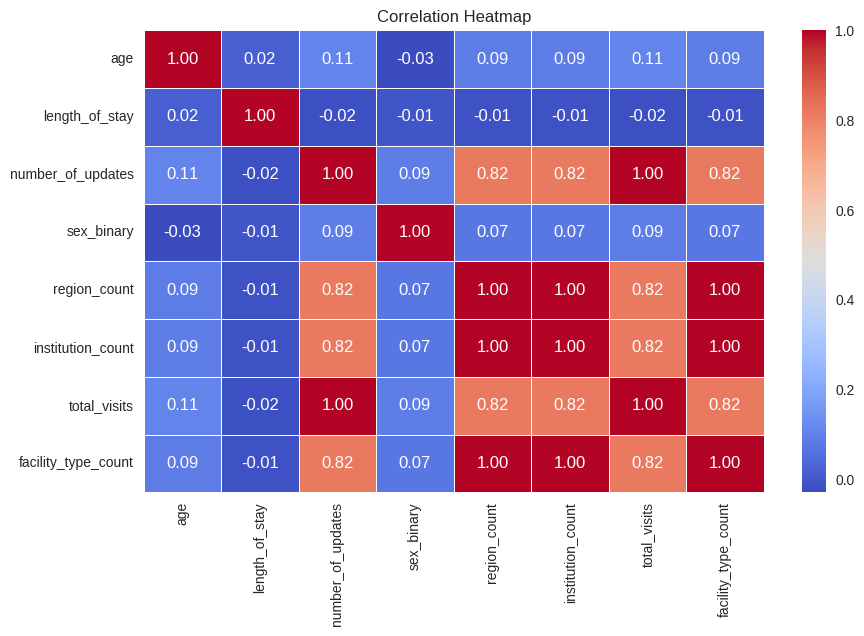

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(merged_data[numeric_columns].corr(), fmt='.2f', annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### Key Insights

**Redundancy:**
- The features `region_count`, `institution_count`, `facility_type_count`, and `total_visits` show strong correlations with one another. This redundancy indicates the potential risk of multicollinearity, which can reduce model performance. Proper feature selection or dimensionality reduction is necessary.

**Predictive Relationships:**
- The feature `total_visits` demonstrates moderate-to-strong correlations with `region_count`, `institution_count`, and `facility_type_count`. These relationships suggest that these features are good predictors and are critical for modeling resource demand.

**Independent Features:**
- The feature `age` is relatively independent, with weak correlations with other features. However, its slight correlation with `total_visits` makes it a valuable inclusion for modeling.

**Weak Predictors:**
- Features such as `length_of_stay` and `sex_binary` exhibit negligible correlations with most other features. Their impact on predictions may be limited but could still contribute marginally to the model’s performance.

### Next Steps

**Feature Selection:**
- Drop `number_of_updates`, as it is perfectly correlated with `total_visits` and adds no unique value.
- From the highly correlated features (`region_count`, `institution_count`, `facility_type_count`), retain only one feature. For this analysis, `region_count` will be retained as a representative feature.

**Dimensionality Reduction:**
- Apply dimensionality reduction techniques such as Principal Component Analysis (PCA) or use regularization techniques like Lasso regression to manage multicollinearity and improve model robustness.

**Modeling Approach:**
- Focus on `total_visits`, `age`, and one or two of the correlated features (e.g., `region_count`) as primary predictors.
- Test the inclusion of weak predictors (`length_of_stay`, `sex_binary`) to evaluate if they add marginal improvements to the model's performance.

By addressing redundancy and emphasizing predictive relationships, the refined feature set will enhance the model's interpretability and accuracy. Further steps will include encoding categorical features, scaling numerical features, and splitting the dataset for model training and evaluation.

# 7. Feature Selection

In [ ]:
# Features to drop
redundant_features = ['number_of_updates', 'institution_count', 'facility_type_count']

# Drop redundant features
filtered_data = merged_data.drop(columns=redundant_features)

# Verify the resulting dataset
print(f"Remaining features: {filtered_data.columns.tolist()}")
print(f"Dataset shape after dropping redundant features: {filtered_data.shape}")


Remaining features: ['visit_type', 'facility_type', 'sex', 'region', 'age', 'length_of_stay', 'age_group', 'sex_binary', 'region_count', 'total_visits']
Dataset shape after dropping redundant features: (179728, 10)


In [ ]:
cat_features=filtered_data.select_dtypes(include='object').columns
num_features=filtered_data.select_dtypes(include='int').columns


# Convert numeric_features and categorical_features to lists
num_features = num_features.tolist()
cat_features = cat_features.tolist()

# Label Encoding
# for cat_feature in cat_features:
#  merged_data[cat_feature] = merged_data[cat_feature].astype('category')
#  merged_data[cat_feature] = merged_data[cat_feature].cat.codes

# merged_data.head()

# 8. Model Training With Pycaret

### Why PyCaret? <br>
PyCaret is a low-code machine learning library that simplifies the process of training and deploying machine learning models. It provides an intuitive interface for performing key tasks such as preprocessing, model comparison, tuning, and deployment, reducing the time and complexity typically associated with traditional workflows.


Before setting up PyCaret, a random sample of 10% size of the dataset will be get to make predictions with unseen data.

In [ ]:

data = filtered_data.sample(frac=0.9, random_state=RANDOM_SEED)
data_unseen = filtered_data.drop(data.index)

# Reset the index
data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

# Create a copy of the unseen data with 'total_visits' retained for plotting
data_unseen_with_actual = data_unseen.copy()
# Dropping the 'total_visits' column from the unseen data cos it our target variable
data_unseen.drop(columns=['total_visits'],inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('columns: ' + str(data.columns))
print("-----------------------------------------------------------")
print('Unseen Data For Predictions: ' + str(data_unseen.shape))
print('columns: ' + str(data_unseen.columns))

Data for Modeling: (161755, 10)
columns: Index(['visit_type', 'facility_type', 'sex', 'region', 'age', 'length_of_stay',
       'age_group', 'sex_binary', 'region_count', 'total_visits'],
      dtype='object')
-----------------------------------------------------------
Unseen Data For Predictions: (17973, 9)
columns: Index(['visit_type', 'facility_type', 'sex', 'region', 'age', 'length_of_stay',
       'age_group', 'sex_binary', 'region_count'],
      dtype='object')


### Pipeline Setup
The setup configuration for PyCaret's experiment (exp01) is designed to enhance data preprocessing, improve model robustness, and optimize predictive performance. Here's how each parameter contributes:

1. Data Scaling: Robust scaling ensures that features with large ranges or extreme outliers (e.g., age and length_of_stay) do not dominate the model.
2. Outlier Detection: Removal of extreme outliers aligns with insights from boxplots and histograms during exploratory analysis.
3. Correlation Analysis: Removing multicollinear features streamlines the dataset by addressing redundancy (e.g., region_count vs. institution_count).
4. Stratification: Ensures model evaluation remains fair and consistent for varying regions or visit types.
5. Target Transformation: Aligns with the skewness observed in the total_visits variable, stabilizing regression models and improving accuracy.

In [ ]:
exp01 = setup(
              session_id=RANDOM_SEED,
              data=data,
              target="total_visits",
              transform_target=True,
              transform_target_method="quantile",
              normalize=True,
              normalize_method ='robust',
              fold_strategy='stratifiedkfold',
              data_split_stratify= True,
              remove_outliers=True,
              remove_multicollinearity=True,
              transformation=True,
              transformation_method="quantile"
                )

,Description,Value
0,Session id,142
1,Target,total_visits
2,Target type,Regression
3,Original data shape,"(161755, 10)"
4,Transformed data shape,"(156093, 21)"
5,Transformed train set shape,"(107566, 21)"
6,Transformed test set shape,"(48527, 21)"
7,Numeric features,4
8,Categorical features,5
9,Preprocess,True


#### Compare Models

##### Model Evaluation Summary

#### Top Model: CatBoost Regressor

The **CatBoost Regressor** achieved the best performance with the following metrics:

- **Mean Absolute Error (MAE):** 2.9117  
  *Indicating the average prediction error is ~2.91 visits.*
- **Mean Squared Error (MSE):** 35.0962  
  *Reflecting the overall error magnitude.*
- **R-Squared (R²):** 0.7129  
  *Showing that ~71% of the variance in the target variable is explained by the model.*

#### Close Competitors

- **XGBoost Regressor** and **LightGBM** also performed well, with MAEs of 2.9213 and 2.9624, respectively.
- However, **CatBoost** outperformed them slightly in all metrics, particularly in R² and RMSE.

#### Lower Performers

- Models like **Linear Regression**, **Lasso**, and **Passive Aggressive Regressor** showed significantly higher errors and negative R² values, making them unsuitable for this use case.
- The **Dummy Regressor**, used as a baseline, had an MAE of 5.7014, indicating most models outperformed the naive approach.


The **CatBoost Regressor** is the most suitable model for this dataset, offering a balance between accuracy (low MAE and RMSE) and explained variance (high R²). It provides a robust prediction framework for optimizing healthcare resource allocation.

In [ ]:
top_model = compare_models(fold=K_FOLDS,
                            sort="MAE",
                            n_select=1,
                            )

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,13:20:01
Status,. . . . . . . . . . . . . . . . . .,Fitting 5 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Huber Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,3.7858,79.0804,8.8926,0.3530,0.5967,0.4729,3.8880
ridge,Ridge Regression,3.7877,79.0799,8.8926,0.3530,0.5969,0.4735,2.6080
br,Bayesian Ridge,3.7878,79.0940,8.8934,0.3529,0.5970,0.4734,2.9060
lar,Least Angle Regression,3.7896,79.3286,8.9066,0.3510,0.5969,0.4726,2.8480
lasso,Lasso Regression,5.7014,145.6006,12.0665,-0.1912,0.9063,0.7127,2.8460
llar,Lasso Least Angle Regression,5.7014,145.6006,12.0665,-0.1912,0.9063,0.7127,2.9640
en,Elastic Net,5.6394,146.6427,12.1096,-0.1997,0.9108,0.5636,2.5880
omp,Orthogonal Matching Pursuit,5.8455,149.1346,12.2121,-0.2201,0.9753,0.6500,3.3440
par,Passive Aggressive Regressor,11.6656,635.1651,23.0454,-4.1964,1.2356,2.0957,2.9160


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,2.9117,35.0962,5.9206,0.7129,0.5493,0.3786,17.7360
xgboost,Extreme Gradient Boosting,2.9213,35.5438,5.9599,0.7092,0.5519,0.3869,3.5420
knn,K Neighbors Regressor,3.0184,36.1724,6.0129,0.7041,0.5691,0.4357,13.2580
rf,Random Forest Regressor,3.0204,37.4831,6.1193,0.6934,0.5580,0.3951,18.9860
lightgbm,Light Gradient Boosting Machine,2.9624,37.7263,6.1393,0.6914,0.5491,0.3720,8.0800
gbr,Gradient Boosting Regressor,3.0316,40.7870,6.3857,0.6663,0.5541,0.3730,8.5880
et,Extra Trees Regressor,3.1128,40.9396,6.3967,0.6651,0.5644,0.4073,19.6680
dt,Decision Tree Regressor,3.1507,44.0607,6.6360,0.6395,0.5687,0.4190,2.9980
ada,AdaBoost Regressor,3.4345,58.0044,7.6128,0.5255,0.5690,0.4336,5.2960
lr,Linear Regression,3.7858,79.0804,8.8926,0.3530,0.5967,0.4729,3.8880


#### Tune model

#### Hyperparameter Optimization Results

The hyperparameter tuning process further refined the CatBoost Regressor, yielding an improved average RMSE of 5.8820 (down from 5.9206 in the initial comparison). The model also demonstrated enhanced consistency across folds, with a lower standard deviation in RMSE (0.1214) compared to the baseline model. Key improvements include:

- **Mean Absolute Error (MAE):** Improved slightly to 2.8997 from 2.9117.
- **R² (Explained Variance):** Increased marginally to 0.7168, reflecting a better fit to the data.
- **Stability:** Standard deviation across folds remained low, indicating reliable model performance.

In [ ]:
# hyperparameter optimization
tuned_model = tune_model(estimator=top_model, fold=10,
                         optimize="RMSE", choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.9221,35.7124,5.9760,0.7139,0.5556,0.3830
1,2.9350,37.5962,6.1316,0.6925,0.5521,0.3807
2,2.9332,34.6580,5.8871,0.7161,0.5538,0.3836
3,2.9134,35.7948,5.9829,0.7051,0.5541,0.3792
4,2.8957,32.4837,5.6994,0.7320,0.5483,0.3812
5,2.8578,32.9111,5.7368,0.7264,0.5472,0.3803
6,2.9190,34.4992,5.8736,0.7174,0.5557,0.3872
7,2.8639,34.4927,5.8730,0.7174,0.5346,0.3805
8,2.8684,33.3515,5.7751,0.7282,0.5455,0.3802


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


# Evalution metrics visulization

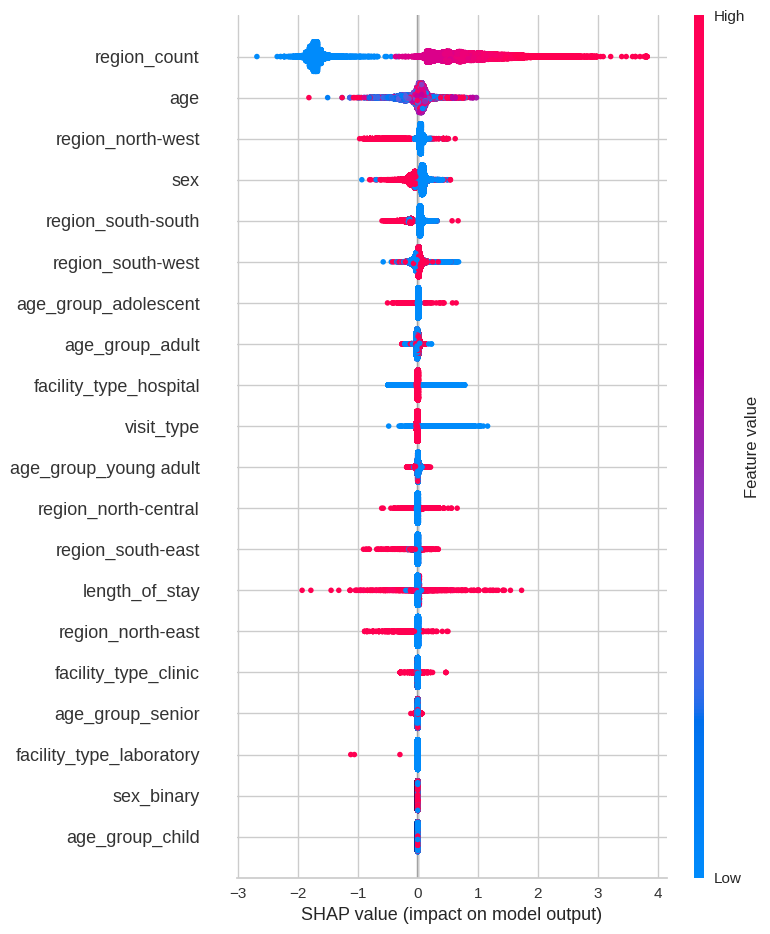

In [ ]:
interpret_model(tuned_model)

The SHAP summary plot provides insights into the impact of individual features on the model's predictions. Key observations include:

- **region_count** and **age** are the most influential features, with higher values leading to increased predictions (positive SHAP values).
- Regional features like **region_north-west**, **region_south-south**, and **region_south-west** also significantly contribute, indicating the importance of geographical factors in predicting visits.
- Demographic variables such as **sex** and **age_group** (e.g., **adolescent** and **adult**) show moderate influence, with varying impacts based on their SHAP values.
- Facility type features, such as **facility_type_hospital**, have a measurable but smaller effect compared to regional and demographic variables.
- Less impactful features include **facility_type_laboratory**, **sex_binary**, and **age_group_child**, contributing minimally to the model's output.

This analysis highlights that resource allocation and regional variations are critical for accurate predictions, with secondary importance given to patient demographics and facility types.

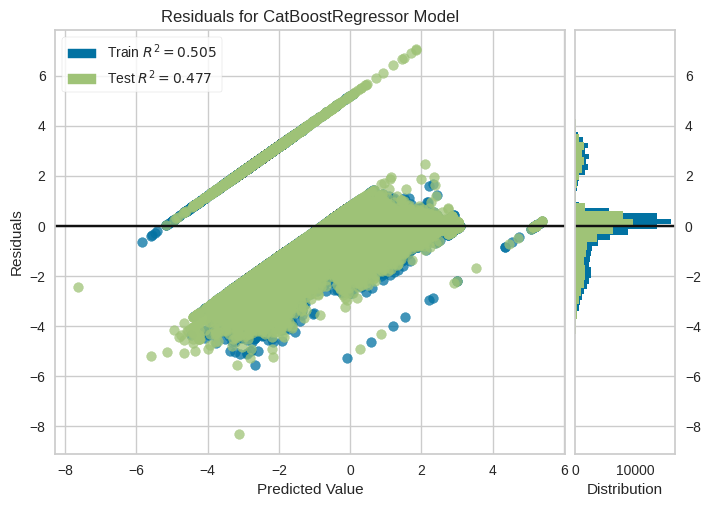

In [ ]:
plot_model(tuned_model, plot="residuals")

The residual plot for the CatBoost Regressor shows the differences between predicted and actual values for both the training and test datasets. The train
R² = 0.505 and test
R² = 0.477 indicate moderate predictive performance. Most residuals are centered around zero, showing reasonable model accuracy. However, there is a pattern of under-predictions (positive residuals) and over-predictions (negative residuals) for some predicted values, suggesting the model struggles with specific ranges. The residual histogram indicates a slightly skewed distribution, implying potential room for improvement in model calibration or feature engineering.

In [ ]:
plot_model(tuned_model, plot="parameter")

,Parameters
nan_mode,Min
eval_metric,RMSE
iterations,270
sampling_frequency,PerTree
leaf_estimation_method,Newton
random_score_type,NormalWithModelSizeDecrease
grow_policy,SymmetricTree
penalties_coefficient,1
boosting_type,Plain
model_shrink_mode,Constant


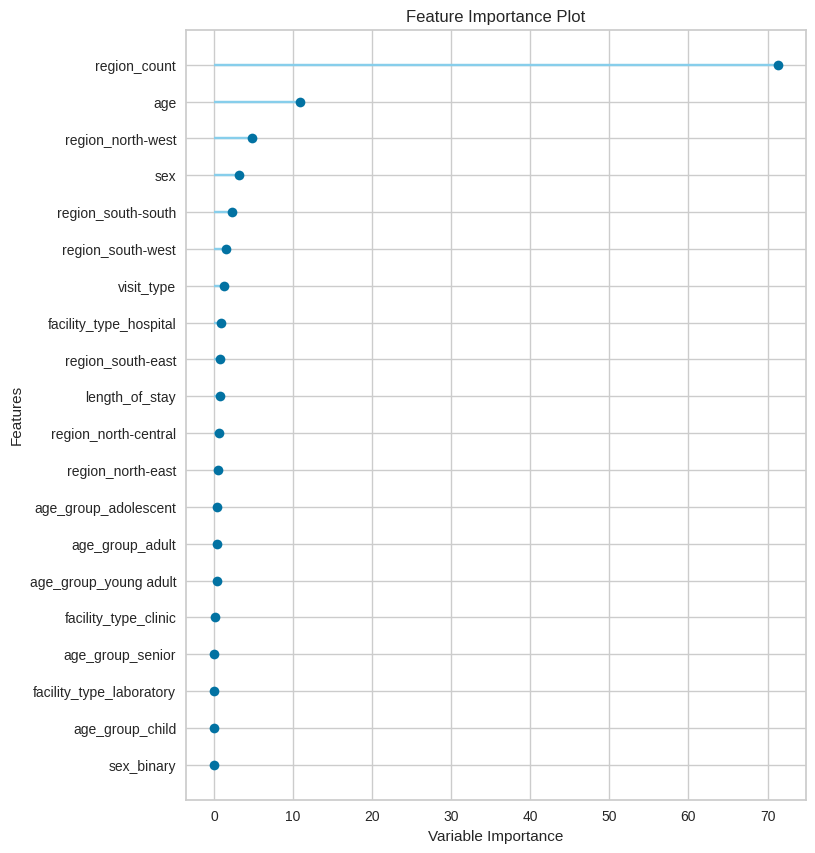

In [ ]:
# Feature importance
plot_model(tuned_model, plot="feature_all")

#### Prediction on Test Data

In [ ]:
# The evaluation metrics are calculated on the test set 30%
predict_model(tuned_model);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,2.8921,34.9648,5.9131,0.7134,0.5528,0.3803


In [ ]:
final_model = finalize_model(tuned_model)

In [ ]:
# The evaluation metrics are calculated on the whole dataset
predict_model(final_model);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,2.8879,35.6634,5.9719,0.7077,0.5498,0.3822


#### Prediction on Unseen Data

In [ ]:
# Predict on unseen data using the finalized model
pred_unseen = predict_model(final_model, data=data_unseen);
pred_unseen.head()

,visit_type,facility_type,sex,region,age,length_of_stay,age_group,sex_binary,region_count,prediction_label
0,out-patient,hospital,female,north-west,96,0,senior,1,1,1.0
1,out-patient,hospital,female,north-central,48,0,adult,1,1,1.0
2,out-patient,hospital,female,south-west,35,0,adult,1,1,1.0
3,out-patient,hospital,female,south-west,34,0,young adult,1,1,1.0
4,out-patient,hospital,female,south-west,79,0,senior,1,2,4.0


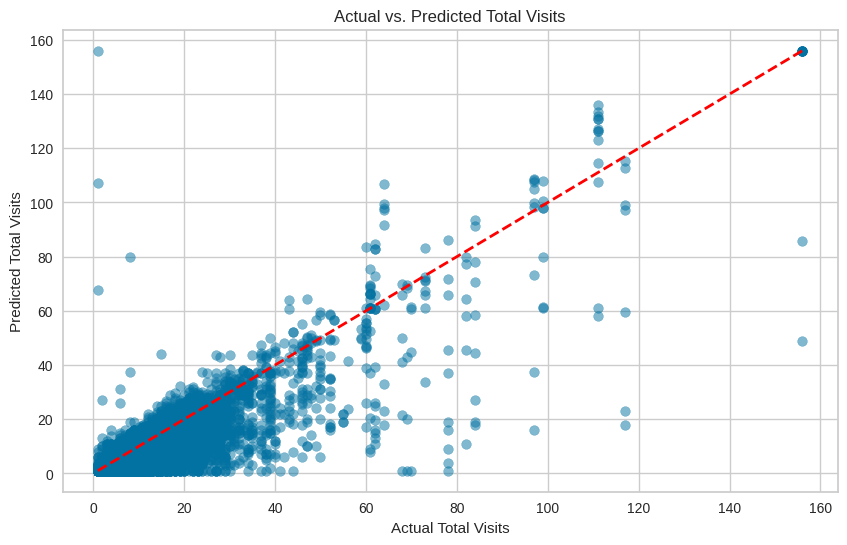

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(data_unseen_with_actual['total_visits'], pred_unseen['prediction_label'], alpha=0.5)
plt.plot([data_unseen_with_actual['total_visits'].min(), data_unseen_with_actual['total_visits'].max()],
         [data_unseen_with_actual['total_visits'].min(), data_unseen_with_actual['total_visits'].max()],
         color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Total Visits')
plt.ylabel('Predicted Total Visits')
plt.title('Actual vs. Predicted Total Visits')
plt.show()


### Results Analysis: CatBoost Regressor

#### Before Finalization:
- **MAE**: 2.8921  
- **RMSE**: 5.9131  
- **R²**: 0.7134  

These metrics suggest good predictive performance, with the model explaining about 71% of the variance in the target variable.

#### After Finalization:
- **MAE**: 2.8879  
- **RMSE**: 5.9719  
- **R²**: 0.7077  

The finalized model shows slight changes, with a marginal increase in RMSE and a slight decrease in R². This is expected as finalization uses the full dataset, potentially introducing minor variance.

#### Actual vs. Predicted Plot:
The scatter plot compares actual total visits to predicted total visits. The red dashed line represents the ideal scenario where predictions perfectly match the actual values. Most data points cluster near this line, indicating the model's strong predictive performance. However, some deviations, particularly for higher values, suggest areas for improvement in capturing extreme cases.

The finalized model maintains strong predictive performance with minimal deviation in metrics, ensuring consistency and reliability for deployment. The actual vs. predicted plot visually confirms the model's accuracy for the majority of predictions.


In [ ]:
# saving the model
save_model(final_model, PATH+"/models"+os.sep+"modelCCP_"+date.today().strftime("%m-%d-%Y"))

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('target_transformation',
                  TransformerWrapperWithInverse(transformer=TargetTransformer(estimator=QuantileTransformer(output_distribution='normal',
                                                                                                            random_state=142)))),
                 ('numerical_imputer',
                  TransformerWrapper(include=['age', 'length_of_stay',
                                              'sex_binary', 'region_count'],
                                     transformer=SimpleImputer())),
                 ('categor...
                                     transformer=RemoveMulticollinearity(threshold=0.9))),
                 ('remove_outliers',
                  TransformerWrapper(transformer=RemoveOutliers(random_state=142))),
                 ('transformation',
                  TransformerWrapper(transformer=QuantileTransformer(output_distribution='normal',
                

# 9. Resource Allocation Optimization

In [ ]:
# Aggregate predicted demand by region
region_demand = pred_unseen.groupby('region')['prediction_label'].sum().reset_index()
region_demand.rename(columns={'prediction_label': 'predicted_visits'}, inplace=True)

# Convert 'predicted_visits' column to integer type
region_demand['predicted_visits'] = region_demand['predicted_visits'].astype(int)

print(region_demand)

          region  predicted_visits
0  north-central             10090
1     north-east              1208
2     north-west              8724
3     south-east              9999
4    south-south             22628
5     south-west             65018


In [ ]:
# Assumtion of the resource data
resource_data = pd.DataFrame({
    'region': ['north-central', 'north-east', 'north-west', 'south-east', 'south-south', 'south-west'],
    'beds_available': [10000, 8000, 15000, 12000, 20000, 50000],
    'staff_available': [3000, 2000, 4000, 3500, 5000, 6000]
})
# Merge predicted demand with resource data
demand_data = resource_data.merge(region_demand, on='region', how='left')
demand_data['predicted_visits'].fillna(0, inplace=True)  # Handle any missing regions
print(demand_data)

          region  beds_available  staff_available  predicted_visits
0  north-central           10000             3000             10090
1     north-east            8000             2000              1208
2     north-west           15000             4000              8724
3     south-east           12000             3500              9999
4    south-south           20000             5000             22628
5     south-west           50000             6000             65018


In [ ]:
from ortools.linear_solver import pywraplp

# Create Solver
solver = pywraplp.Solver.CreateSolver('GLOP')

# Decision Variables: Beds allocated per region
x = {}
unmet_demand = {}
for i, row in demand_data.iterrows():
    x[i] = solver.NumVar(0, row['beds_available'], f'x_{i}')
    unmet_demand[i] = solver.NumVar(0, solver.infinity(), f'unmet_demand_{i}')

# Objective Function: Minimize unmet demand
objective = solver.Objective()
for i in range(len(demand_data)):
    objective.SetCoefficient(unmet_demand[i], 1)  # Minimize unmet demand
objective.SetMinimization()

# Constraints: Ensure allocated beds do not exceed available beds
for i, row in demand_data.iterrows():
    solver.Add(x[i] <= row['beds_available'])  # Beds constraint

# Constraints: Ensure allocated beds do not exceed staff availability
for i, row in demand_data.iterrows():
    solver.Add(x[i] <= row['staff_available'] * 100)  # Assuming each staff can handle 100 beds

# Constraints: Ensure unmet demand is correctly calculated
for i, row in demand_data.iterrows():
    solver.Add(unmet_demand[i] >= row['predicted_visits'] - x[i])

# Solve
status = solver.Solve()

# Results
if status == pywraplp.Solver.OPTIMAL:
    print("Optimal allocation:")
    for i, row in demand_data.iterrows():
        print(f"Region: {row['region']}, Beds Allocated: {x[i].solution_value()}, Unmet Demand: {unmet_demand[i].solution_value()}")
else:
    print("No optimal solution found.")


Optimal allocation:
Region: north-central, Beds Allocated: 10000.0, Unmet Demand: 90.0
Region: north-east, Beds Allocated: 8000.0, Unmet Demand: 0.0
Region: north-west, Beds Allocated: 15000.0, Unmet Demand: 0.0
Region: south-east, Beds Allocated: 12000.0, Unmet Demand: 0.0
Region: south-south, Beds Allocated: 20000.0, Unmet Demand: 2628.0
Region: south-west, Beds Allocated: 50000.0, Unmet Demand: 15018.0


### Key Insights:

- **Sufficient Resources in Some Regions:** North-east, north-west, and south-east meet predicted demands with no unmet needs.
- **High Unmet Demand:** South-south (2,628 patients) and south-west (15,018 patients) face significant resource shortages.
- **Over-allocated Resources:** Regions like north-central and south-west may strain existing staff and facilities.
- **Staffing Constraints:** Insufficient staff in high-demand regions, such as south-west, may create bottlenecks.

### Recommendations:

1. **Augment Resources:** Increase beds and staff in south-south and south-west regions. Consider mobile healthcare units.
2. **Redistribute Capacity:** Shift resources from regions with excess capacity (e.g., north-central) to high-demand areas.
3. **Expand Staffing:** Train and deploy more healthcare workers in under-staffed regions.
4. **Use Decision Tools:** Implement systems to monitor real-time demand and forecast spikes.
5. **Collaborate with Stakeholders:** Partner with healthcare providers and local governments to address gaps.

### Summary:

Efficient resource redistribution, staffing scale-up, and proactive monitoring can address high unmet demand in south-south and south-west, ensuring equitable healthcare delivery.

# 10. Deployment Plan for Healthcare Resource Allocation Model

## 1. Deployment Strategy

**Goal:** Deploy a healthcare resource allocation model that predicts patient visits and optimizes resource usage using Streamlit for prototyping and FastAPI for production deployment.

### Prototype Deployment with Streamlit:

- **Use the developed Streamlit app to:**
  - Predict patient visits.
  - Optimize healthcare resource allocation.
  - Allow users to input details manually or upload files for batch predictions.
  - Provide a visual representation of resource allocation plans.
- **Benefits:**
  - Easy user interaction for stakeholders.
  - Rapid feedback for further improvements.

### Streamlit App Link

[Streamlit App Link Here](https://healthcare-resource-allocation.streamlit.app/)

### Production Deployment with FastAPI:

- **Transition the Streamlit logic into a FastAPI backend for a scalable and production-ready system.**
- **Expose RESTful APIs for:**
  - **Prediction:** Predict patient visits based on the input.
  - **Optimization:** Generate a resource allocation plan based on predicted demand.
- **Use Docker to containerize the FastAPI service for consistent deployment across environments.**

### Model Management with MLflow:

- **Model Versioning:** Store all trained models in MLflow to track versions and performance metrics.
- **Model Registry:** Use MLflow's model registry for seamless promotion of models from staging to production.
- **Deploy the production-ready model directly from MLflow.**

## 2. Integration Steps

### Frontend Integration:

- **For production, integrate the FastAPI endpoints into existing hospital management systems or a custom-built dashboard.**
- **Use React.js or Angular for the frontend for better scalability if Streamlit is not suitable for production.**

### Backend Integration:

- **Replace the Streamlit backend with FastAPI endpoints.**
- **Set up API routes for batch and real-time predictions:**
  - `/predict`: Accepts JSON or CSV for predictions.
  - `/optimize`: Accepts predictions and available resources to generate allocation plans.

### Data Pipeline Integration:

- **Automate data preprocessing and input via ETL tools like Apache Airflow.**
- **Connect the app to hospital databases to retrieve real-time patient and resource data.**

## 3. Monitoring Procedures

### Model Performance Monitoring:

- **Log model metrics (e.g., MAE, RMSE, R²) to MLflow.**
- **Continuously monitor production performance for drift or degradation.**

### Application Monitoring:

- **Use tools like Prometheus and Grafana to monitor API response times, throughput, and errors.**
- **Implement log aggregation using ELK Stack (Elasticsearch, Logstash, Kibana).**

### Drift Detection and Alerts:

- **Detect data drift and concept drift by comparing live input distributions with training data.**
- **Set up automated alerts for significant deviations.**

## 4. Scalability Strategies

### Horizontal Scaling:

- **Use Kubernetes to scale the FastAPI service based on traffic.**
- **Implement load balancers like AWS ALB or Nginx for efficient traffic distribution.**

### Caching:

- **Cache frequent predictions and resource allocation plans using Redis.**

### Dynamic Resource Allocation:

- **Develop algorithms to dynamically allocate computing resources based on traffic patterns.**

### Serverless Architecture:

- **Deploy prediction and optimization APIs as serverless functions (e.g., AWS Lambda) for cost-effective scaling.**

## 5. MLflow Integration

### Model Experimentation:

- **Store model metrics (e.g., MAE, RMSE, R²) and hyperparameters in MLflow during experimentation.**
- **Visualize performance comparisons across models and versions.**

### Model Deployment:

- **Deploy the model directly from MLflow's Model Registry into the FastAPI backend.**
- **Automate the deployment pipeline to promote models based on evaluation thresholds.**

### Model Updates:

- **Enable dynamic model updates by pulling the latest version from MLflow into production without service interruption.**

## 6. Security and Compliance

### Secure APIs:

- **Use API keys or OAuth2 for authentication.**
- **Encrypt all data in transit (TLS) and at rest (AES-256).**

### Data Privacy:

- **Anonymize sensitive patient data before processing.**
- **Ensure compliance with healthcare regulations (e.g., HIPAA, GDPR).**

### Role-Based Access Control (RBAC):

- **Restrict access to APIs and monitoring dashboards based on user roles.**

## 7. Testing and Feedback

### Testing:

- **Use Postman for API testing and validation.**
- **Perform unit, integration, and load testing on FastAPI endpoints using pytest and locust.**

### Feedback Loop:

- **Incorporate feedback from stakeholders using the Streamlit app prototype to refine the production system.**

### A/B Testing:

- **Experiment with different resource allocation strategies to identify the most effective approach.**

## 8. Maintenance and Continuous Improvement

### Retraining Pipeline:

- **Set up an automated pipeline to retrain the model using new data periodically.**
- **Store retraining metrics in MLflow for transparency.**

### Version Control:

- **Maintain version control for the FastAPI service and MLflow configurations using Git.**

### Feature Updates:

- **Continuously enhance the FastAPI service with additional features, such as real-time allocation adjustments or predictive analytics for future demands.**

## Summary

This deployment plan ensures a robust, scalable, and secure deployment of the healthcare resource allocation model. With regular monitoring, feedback, and scalability measures in place, the system is prepared to handle dynamic healthcare demands while maintaining performance and compliance.

